# Meta-Analysis with NiMARE

## What is NiMARE?

![NiMARE banner](images/nimare_banner.png)

[NiMARE](https://nimare.readthedocs.io/en/0.0.12/) is a Python library for performing neuroimaging meta-analyses and related analyses, like automated annotation and functional decoding. The goal of NiMARE is to centralize and standardize implementations of common meta-analytic tools, so that researchers can use whatever tool is most appropriate for a given research question.

There are already a number of tools for neuroimaging meta-analysis:

| <h2>Tool</h2> | <h2>Scope</h2> |
| :------------ | :------------- |
| <a href="https://brainmap.org"><img src="images/brainmap_logo.png" alt="BrainMap" width="400"/></a> | BrainMap includes a suite of applications for (1) searching its manually-annotated coordinate-based database, (2) adding studies to the database, and (3) running ALE meta-analyses. While search results can be extracted using its Sleuth app, access to the full database requires a collaborative use agreement. |
| <a href="https://brainmap.org"><img src="images/neurosynth_logo.png" alt="Neurosynth" width="200"/></a> | Neurosynth provides (1) a large, automatically-extracted coordinate-based database, (2) a website for performing large-scale automated meta-analyses, and (3) a Python library for performing meta-analyses and functional decoding, mostly relying on a version of the MKDA algorithm. The Python library has been deprecated in favor of `NiMARE`. |
| <a href="https://www.neurovault.org"><img src="images/neurovault_logo.png" alt="Neurovault" width="200"/></a> | Neurovault is a repository for sharing unthresholded statistical images, which can be used to search for images to use in image-based meta-analyses. Neurovault provides a tool for basic meta-analyses and an integration with Neurosynth's database for online functional decoding. |
| <a href="https://www.sdmproject.com"><img src="images/sdm_logo.png" alt="SDM" width="200"/></a> | The Seed-based _d_ Mapping (SDM) app provides a graphical user interface and SPM toolbox for performing meta-analyses with the SDM algorithm, which supports a mix of coordinates and images. |
| <a href="https://github.com/canlab/Canlab_MKDA_MetaAnalysis"><img src="images/mkda_logo.png" alt="MKDA" width="200"/></a> | The MATLAB-based MKDA toolbox includes functions for performing coordinate-based meta-analyses with the MKDA algorithm. |

The majority of the above tools are (1) closed source, (2) based on graphical user interfaces, and/or (3) written in a programming language that is rarely used by neuroimagers, such as Java. 

In addition to these established tools, there are always interesting new methods that are described in journal articles, but which are never translated to a well-documented and supported implementation.

NiMARE attempts to consolidate the different algorithms that are currently spread out across a range of tools (or which never make the jump from paper to tool), while still ensuring that the original tools and papers can be cited appropriately.

## NiMARE's design philosophy

NiMARE's API is designed to be similar to that of [`scikit-learn`](https://scikit-learn.org/stable/), in that most tools are custom classes. These classes follow the following basic structure:

1. Initialize the class with general parameters
```python
cls = Class(param1, param2)
```

2. For Estimator classes, apply a `fit` method to a `Dataset` object to generate a `MetaResult` object
```python
result = cls.fit(dataset)
```

3. For Transformer classes, apply a `transform` method to an object to return a transformed version of that object

    - An example transformer that accepts a `Dataset`:
```python
dataset = cls.transform(dataset)
```
    - A transformer that accepts a `MetaResult`:
```python
result = cls.transform(result)
```

## Stability and consistency

NiMARE is currently in alpha development, so we appreciate any feedback or bug reports users can provide. Given its status, NiMARE's API may change in the future.

Usage questions can be submitted to [NeuroStars with the 'nimare' tag](https://neurostars.org/tag/nimare), while bug reports and feature requests can be submitted to [NiMARE's issue tracker](https://github.com/neurostuff/NiMARE/issues).

# Goals for this tutorial

1. Compiling meta-analytic datasets
1. Working with NiMARE meta-analytic datasets
1. Searching large datasets
1. Performing coordinate-based meta-analyses
1. Performing image-based meta-analyses
1. Performing functional decoding using Neurosynth

In [1]:
# Import the packages we'll need for this tutorial
%matplotlib inline
import json
import logging
import pprint
import os

import matplotlib.pyplot as plt
from nilearn import plotting, reporting

import nimare

# Don't show debugging or info logs
logging.getLogger().setLevel(logging.WARNING)

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [2]:
DATA_DIR = "/home/jovyan/shared/meta-analysis/osfstorage"

# Collecting and preparing data for meta-analysis

NiMARE relies on a specification for meta-analytic datasets named [NIMADS](https://github.com/neurostuff/NIMADS). Under NIMADS, meta-analytic datasets are stored as JSON files, with information about peak coordinates, _relative_ links to any unthresholded statistical images, metadata, annotations, and raw text.

**NOTE**: NiMARE users generally do not need to create JSONs manually, so we won't go into that structure in this tutorial. Instead, users will typically have access to datasets stored in more established formats, like [Neurosynth](https://github.com/neurosynth/neurosynth-data) and [Sleuth](http://brainmap.org/sleuth/) files.

NiMARE datasets typically come from one of three formats:

1. Text files generated by BrainMap's Sleuth tool
1. Large database files from Neurosynth and NeuroQuery
1. NIMADS-format JSON files

## Sleuth text files

BrainMap users search for papers in the Sleuth app, which can output a text file. This text file can be used by BrainMap's GingerALE tool, as well as by NiMARE.

The example file we will use is from [Laird et al. (2015)](https://doi.org/10.1016/j.neuroimage.2015.06.044), which analyzed face paradigms.

In [3]:
sleuth_file = os.path.join(DATA_DIR, "Laird2015_faces.txt")

with open(sleuth_file, "r") as fo:
    contents = fo.readlines()

print("".join(contents[:40]))

// Reference=Talairach
// Dade, 2001: Face Working Memory - Baseline
// Subjects=12
-33.67	46.54	9.81
30.95	51.15	6.42
-27.22	43.67	21.39
-37.84	.29	43.97
-40.54	15.06	37
34.32	27.33	43.36
-43.89	38.23	-3.61
-30.94	23.82	9.83
6.14	13.72	50.07
-.36	-29.45	23.07
9.11	24.4	34.71
13.91	33.84	22.89
-8.96	-.21	59.61
14.5	5.71	54.94
27.54	-3.13	57.99
-31.49	-29.03	55.24
-6.22	-30.07	54.55
-59.09	-31.42	-6.65
60.69	-33.91	-8.17
-13.78	-38.99	60.06
-38.92	-48.49	39.16
-6.25	-64.98	41.82
35.86	-57.9	44.68
4.97	-68.74	40.75

// Leveroni, 2000: Famous Faces > Newly-learned Faces
// Subjects=11
-15	33	44
10	47	25
12	40	45
-6	49	-4
49	-1	13
-36	15	50
32	32	-7
11	21	-7
9	35	-13
-6	39	-14



In [4]:
dset = nimare.io.convert_sleuth_to_dataset(sleuth_file)
print(dset)

Dataset(386 experiments, space='ale_2mm')


## Neurosynth and NeuroQuery databases

Neurosynth and NeuroQuery are very large databases of coordinates.

NiMARE contains tools for downloading and converting these databases to NiMARE Datasets.

```python
from nimare import extract, io

# Download the desired version of Neurosynth from GitHub.
files = extract.fetch_neurosynth(
    data_dir=DATA_DIR,
    version="7",
    source="abstract",
    vocab="terms",
    overwrite=False,
)

# Select the appropriate set of files
neurosynth_db = files[0]

# Convert the set of files to a Dataset object
neurosynth_dset = io.convert_neurosynth_to_dataset(
    coordinates_file=neurosynth_db["coordinates"],  # Peak coordinates
    metadata_file=neurosynth_db["metadata"],  # Study metadata
    annotations_files=neurosynth_db["features"],  # Terms extracted from abstracts and study-wise weights
)

# Reduce the Dataset to the first 500 studies for the tutorial
neurosynth_dset = neurosynth_dset.slice(neurosynth_dset.ids[:500])

# Save the Dataset to a file
neurosynth_dset.save(os.path.join(DATA_DIR, "neurosynth_dset.pkl.gz"))
```

For this tutorial, we will use a pre-generated Dataset object containing the first 500 studies from the Neurosynth database.

In [5]:
neurosynth_dset = nimare.dataset.Dataset.load(os.path.join(DATA_DIR, "neurosynth_dataset.pkl.gz"))
print(neurosynth_dset)

Dataset(500 experiments, space='mni152_2mm')


## NIMADS JSON files

We will start by loading a dataset in NIMADS format, because this particular dataset contains both coordinates and images. This dataset is created from [Collection 1425 on NeuroVault](https://identifiers.org/neurovault.collection:1425), which contains [NIDM-Results packs](http://nidm.nidash.org/specs/nidm-results_130.html) for 21 pain studies.

In [6]:
nimads_file = os.path.join(DATA_DIR, "nidm_pain_dset.json")

with open(nimads_file, "r") as fo:
    contents = fo.readlines()

print("".join(contents[:80]))

{
    "pain_01.nidm": {
        "contrasts": {
            "1": {
                "coords": {
                    "space": "MNI",
                    "x": [
                        48.0,
                        54.0,
                        60.0,
                        60.0,
                        38.0,
                        44.0,
                        52.0,
                        36.0,
                        -36.0,
                        26.0,
                        12.0,
                        -2.0,
                        -60.0,
                        -56.0,
                        -50.0,
                        -56.0
                    ],
                    "y": [
                        -38.0,
                        -46.0,
                        -30.0,
                        -58.0,
                        46.0,
                        -6.0,
                        -4.0,
                        -12.0,
                        -68.0,
                        -80.0,
  

In [7]:
nimads_dset = nimare.dataset.Dataset(nimads_file)

# In addition to loading the NIMADS-format JSON file,
# we need to download the associated statistical images from NeuroVault,
# for which NiMARE has a useful function.
nimads_dset_images_dir = nimare.extract.download_nidm_pain(data_dir=DATA_DIR)

# We then notify the Dataset about the location of the images,
# so that the *relative paths* in the Dataset can be used to determine *absolute paths*.
nimads_dset.update_path(nimads_dset_images_dir)

# Basics of NiMARE datasets

In NiMARE, datasets are stored in a special `Dataset` class. The `Dataset` class stores most relevant information as properties.

The full list of identifiers in the Dataset is located in `Dataset.ids`. Identifiers are composed of two parts- a study ID and a contrast ID. Within the Dataset, those two parts are separated with a `-`.

In [8]:
print(nimads_dset.ids)

['pain_01.nidm-1' 'pain_02.nidm-1' 'pain_03.nidm-1' 'pain_04.nidm-1'
 'pain_05.nidm-1' 'pain_06.nidm-1' 'pain_07.nidm-1' 'pain_08.nidm-1'
 'pain_09.nidm-1' 'pain_10.nidm-1' 'pain_11.nidm-1' 'pain_12.nidm-1'
 'pain_13.nidm-1' 'pain_14.nidm-1' 'pain_15.nidm-1' 'pain_16.nidm-1'
 'pain_17.nidm-1' 'pain_18.nidm-1' 'pain_19.nidm-1' 'pain_20.nidm-1'
 'pain_21.nidm-1']


Most other information is stored in `pandas` DataFrames. The five DataFrame-based attributes are `Dataset.metadata`, `Dataset.coordinates`, `Dataset.images`, `Dataset.annotations`, and `Dataset.texts`.

Each DataFrame contains at least three columns: `study_id`, `contrast_id`, and `id`, which is the combined `study_id` and `contrast_id`.

In [9]:
nimads_dset.coordinates.head()

,id,study_id,contrast_id,x,y,z,space
0,pain_01.nidm-1,pain_01.nidm,1,48.0,-38.0,-24.0,mni152_2mm
14,pain_01.nidm-1,pain_01.nidm,1,-50.0,-42.0,-24.0,mni152_2mm
13,pain_01.nidm-1,pain_01.nidm,1,-56.0,-62.0,-6.0,mni152_2mm
12,pain_01.nidm-1,pain_01.nidm,1,-60.0,-52.0,-10.0,mni152_2mm
11,pain_01.nidm-1,pain_01.nidm,1,-2.0,-104.0,-2.0,mni152_2mm


In [10]:
nimads_dset.metadata.head()

,id,study_id,contrast_id,sample_sizes
0,pain_01.nidm-1,pain_01.nidm,1,[25]
1,pain_02.nidm-1,pain_02.nidm,1,[25]
2,pain_03.nidm-1,pain_03.nidm,1,[20]
3,pain_04.nidm-1,pain_04.nidm,1,[20]
4,pain_05.nidm-1,pain_05.nidm,1,[9]


In [11]:
nimads_dset.images.head()

,id,study_id,contrast_id,beta__relative,se__relative,t__relative,z__relative,beta,se,t,z
0,pain_01.nidm-1,pain_01.nidm,1,pain_01.nidm/Contrast.nii.gz,pain_01.nidm/ContrastStandardError.nii.gz,pain_01.nidm/TStatistic.nii.gz,None,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,None
1,pain_02.nidm-1,pain_02.nidm,1,pain_02.nidm/Contrast.nii.gz,pain_02.nidm/ContrastStandardError.nii.gz,pain_02.nidm/TStatistic.nii.gz,None,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,None
2,pain_03.nidm-1,pain_03.nidm,1,pain_03.nidm/Contrast.nii.gz,pain_03.nidm/ContrastStandardError.nii.gz,pain_03.nidm/TStatistic.nii.gz,None,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,None
3,pain_04.nidm-1,pain_04.nidm,1,pain_04.nidm/Contrast.nii.gz,pain_04.nidm/ContrastStandardError.nii.gz,pain_04.nidm/TStatistic.nii.gz,None,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,None
4,pain_05.nidm-1,pain_05.nidm,1,pain_05.nidm/Contrast.nii.gz,pain_05.nidm/ContrastStandardError.nii.gz,pain_05.nidm/TStatistic.nii.gz,None,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,None


In [12]:
nimads_dset.annotations.head()

,id,study_id,contrast_id
0,pain_01.nidm-1,pain_01.nidm,1
1,pain_02.nidm-1,pain_02.nidm,1
2,pain_03.nidm-1,pain_03.nidm,1
3,pain_04.nidm-1,pain_04.nidm,1
4,pain_05.nidm-1,pain_05.nidm,1


In [13]:
# The faces Dataset doesn't have any annotations, but the Neurosynth one does
neurosynth_dset.annotations.head()

,id,study_id,contrast_id,terms_abstract_tfidf__001,terms_abstract_tfidf__01,terms_abstract_tfidf__05,terms_abstract_tfidf__10,terms_abstract_tfidf__100,terms_abstract_tfidf__11,terms_abstract_tfidf__12,...,terms_abstract_tfidf__yield,terms_abstract_tfidf__yielded,terms_abstract_tfidf__young,terms_abstract_tfidf__young adults,terms_abstract_tfidf__young healthy,terms_abstract_tfidf__young older,terms_abstract_tfidf__younger,terms_abstract_tfidf__younger adults,terms_abstract_tfidf__youth,terms_abstract_tfidf__zone
26,10022492-1,10022492,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,10022494-1,10022494,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,10022496-1,10022496,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,10051677-1,10051677,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,10191322-1,10191322,1,0.0,0.0,0.0,0.0,0.0,0.0,0.079103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# None of the example Datasets have texts
nimads_dset.texts.head()

,id,study_id,contrast_id
0,pain_01.nidm-1,pain_01.nidm,1
1,pain_02.nidm-1,pain_02.nidm,1
2,pain_03.nidm-1,pain_03.nidm,1
3,pain_04.nidm-1,pain_04.nidm,1
4,pain_05.nidm-1,pain_05.nidm,1


Other relevant attributes are `Dataset.masker` and `Dataset.space`.

`Dataset.masker` is a [nilearn Masker object](https://nilearn.github.io/stable/manipulating_images/masker_objects.html#), which specifies the manner in which voxel-wise information like peak coordinates and statistical images are mapped into usable arrays. Most meta-analytic tools within NiMARE accept a `masker` argument, so the Dataset's masker can be overridden in most cases.

`Dataset.space` is just a string describing the standard space and resolution in which data within the Dataset are stored.

In [15]:
nimads_dset.masker

NiftiMasker(mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f4ad20aebd0>)

In [16]:
nimads_dset.space

'mni152_2mm'

Datasets can also be saved to, and loaded from, binarized (pickled) files.

We cannot save files on Binder, so here is the code we would use to save the pain Dataset:

```python
nimads_dset.save("pain_dataset.pkl.gz")
```

## Searching large datasets

The `Dataset` class contains multiple methods for selecting subsets of studies within the dataset.
We will use the **Neurosynth** Dataset for this section.

One common approach is to search by "labels" or "terms" that apply to studies. In Neurosynth, labels are derived from term frequency within abstracts.

The `slice` method creates a reduced `Dataset` from a list of IDs.

In [17]:
pain_ids = neurosynth_dset.get_studies_by_label("terms_abstract_tfidf__pain", label_threshold=0.001)
ns_pain_dset = neurosynth_dset.slice(pain_ids)
print(ns_pain_dset)

Dataset(14 experiments, space='mni152_2mm')


A MACM (meta-analytic coactivation modeling) analysis is generally performed by running a meta-analysis on studies with a peak in a region of interest, so Dataset includes two methods for searching based on the locations of coordinates: `Dataset.get_studies_by_coordinate` and `Dataset.get_studies_by_mask`.

In [18]:
sphere_ids = neurosynth_dset.get_studies_by_coordinate(
    [[24, -2, -20]],  # The XYZ coordinates to search. There can be more than one.
    r=6,  # The radius around the coordinates in which to search.
)
sphere_dset = neurosynth_dset.slice(sphere_ids)
print(sphere_dset)

Dataset(11 experiments, space='mni152_2mm')


# Running meta-analyses

## Coordinate-based meta-analysis

NiMARE implements multiple coordinate-based meta-analysis methods, including ALE, MKDA chi-squared analysis, MKDA density analysis, and SCALE.

Meta-analytic Estimators are initialized with parameters which determine how the Estimator will be run. For example, ALE accepts a kernel transformer (which defaults to the standard `ALEKernel`), a null method, the number of iterations used to define the null distribution, and the number of cores to be used during fitting.

The Estimators also have a `fit` method, which accepts a `Dataset` object and returns a `MetaResult` object. [`MetaResult`s](https://nimare.readthedocs.io/en/0.0.12/generated/nimare.results.MetaResult.html#nimare.results.MetaResult) link statistical image names to numpy arrays, and can be used to produce nibabel images from those arrays, as well as save the images to files.

In [19]:
meta = nimare.meta.cbma.ale.ALE(null_method="approximate")
meta_results = meta.fit(nimads_dset)

In [20]:
print(type(meta_results))

<class 'nimare.results.MetaResult'>


In [21]:
print(type(meta_results.maps))
print("Available maps:")
print("\t- " + "\n\t- ".join(meta_results.maps.keys()))

<class 'dict'>
Available maps:
	- stat
	- p
	- z


In [22]:
z_img = meta_results.get_map("z")
print(type(z_img))

<class 'nibabel.nifti1.Nifti1Image'>


/srv/conda/envs/notebook/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


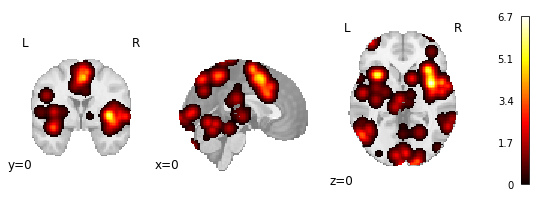

In [23]:
plotting.plot_stat_map(
    z_img,
    draw_cross=False,
    cut_coords=[0, 0, 0],
)

## Multiple comparisons correction

Most of the time, you will want to follow up your meta-analysis with some form of multiple comparisons correction. For this, NiMARE provides Corrector classes in the `correct` module. Specifically, there are two Correctors: [`FWECorrector`](https://nimare.readthedocs.io/en/0.0.12/generated/nimare.correct.FWECorrector.html) and [`FDRCorrector`](https://nimare.readthedocs.io/en/0.0.12/generated/nimare.correct.FDRCorrector.html). In both cases, the Corrector supports a range of naive correction options that are not optimized for neuroimaging data, like Bonferroni correction.

In addition to generic multiple comparisons correction, the Correctors also reference algorithm-specific correction methods, such as the `montecarlo` method supported by most coordinate-based meta-analysis algorithms.

Correctors are initialized with parameters, and they have a `transform` method that accepts a `MetaResult` object and returns an updated one with the corrected maps.

In [24]:
mc_corrector = nimare.correct.FWECorrector(
    method="montecarlo",
    n_iters=50,  # Use >=10000 for a real analysis
    n_cores=1,
)
mc_results = mc_corrector.transform(meta_results)

# Let's store the CBMA result for later
cbma_z_img = mc_results.get_map("z_desc-size_level-cluster_corr-FWE_method-montecarlo")

  0%|          | 0/50 [00:00<?, ?it/s]

In [25]:
print(type(mc_results.maps))
print("Available maps:")
print("\t- " + "\n\t- ".join(mc_results.maps.keys()))

<class 'dict'>
Available maps:
	- stat
	- p
	- z
	- logp_level-voxel_corr-FWE_method-montecarlo
	- z_level-voxel_corr-FWE_method-montecarlo
	- logp_desc-size_level-cluster_corr-FWE_method-montecarlo
	- z_desc-size_level-cluster_corr-FWE_method-montecarlo
	- logp_desc-mass_level-cluster_corr-FWE_method-montecarlo
	- z_desc-mass_level-cluster_corr-FWE_method-montecarlo


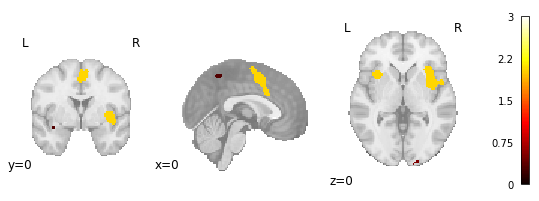

In [26]:
plotting.plot_stat_map(
    mc_results.get_map("z_desc-size_level-cluster_corr-FWE_method-montecarlo"),
    draw_cross=False,
    cut_coords=[0, 0, 0],
    vmax=3,
)

In [27]:
# Report a standard cluster table for the meta-analytic map using a threshold of p<0.05
reporting.get_clusters_table(cbma_z_img, stat_threshold=1.65)

/srv/conda/envs/notebook/lib/python3.7/site-packages/nilearn/reporting/_get_clusters_table.py:99: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body.
  "Attention: At least one of the (sub)peaks falls outside of the "


,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-58.0,-26.0,22.0,2.053749,1584
1,2,-32.0,-62.0,-38.0,NaN,2632
2,3,-34.0,14.0,0.0,NaN,1160
3,4,0.0,8.0,46.0,NaN,5320
4,5,38.0,8.0,-2.0,NaN,6488
5,6,54.0,-26.0,20.0,NaN,1608


NiMARE also has diagnostic tools to characterize results

In [28]:
focus = nimare.diagnostics.FocusCounter(target_image="z_desc-size_level-cluster_corr-FWE_method-montecarlo")
focus_table, focus_img = focus.transform(mc_results)
focus_table

  0%|          | 0/21 [00:00<?, ?it/s]

,1,2,3,4,5,6,7,8,9
Cluster ID,,,,,,,,,
Center of Mass,"(-58, -26, 21)","(-31, -61, -37)","(-36, 4, -14)","(-34, 14, 0)","(0, 7, 46)","(-3, -48, 53)","(18, -101, -4)","(38, 7, -2)","(53, -26, 19)"
pain_01.nidm-1,0,1,0,0,0,0,0,1,0
pain_02.nidm-1,0,0,1,0,0,0,0,0,1
pain_03.nidm-1,0,1,0,0,4,0,1,1,0
pain_04.nidm-1,0,1,1,1,3,0,2,2,2
pain_05.nidm-1,0,1,0,0,2,0,0,3,0
pain_06.nidm-1,0,0,0,0,1,0,0,0,0
pain_07.nidm-1,0,0,0,0,0,0,0,0,0
pain_08.nidm-1,0,1,0,0,1,1,0,0,1


In [29]:
jackknife = nimare.diagnostics.Jackknife(target_image="z_desc-size_level-cluster_corr-FWE_method-montecarlo")
jackknife_table, jackknife_img = jackknife.transform(mc_results)
jackknife_table

  0%|          | 0/21 [00:00<?, ?it/s]

,1,2,3,4,5,6,7,8,9
Cluster ID,,,,,,,,,
Center of Mass,"(-58, -26, 21)","(-31, -61, -37)","(-36, 4, -14)","(-34, 14, 0)","(0, 7, 46)","(-3, -48, 53)","(18, -101, -4)","(38, 7, -2)","(53, -26, 19)"
pain_01.nidm-1,0.0,0.073695,0.0,0.0,0.0,0.0,0.058134,0.032443,0.0
pain_02.nidm-1,0.0,0.0,0.345659,0.000024,0.0,0.0,0.000014,0.000006,0.142421
pain_03.nidm-1,0.0,0.109131,0.0,0.0,0.134174,0.0,0.385138,0.023071,0.0
pain_04.nidm-1,0.0,0.076218,0.293601,0.184233,0.113124,0.0,0.395319,0.079341,0.231365
pain_05.nidm-1,0.0,0.12414,0.067818,0.037756,0.083693,0.0,0.0,0.093972,0.0
pain_06.nidm-1,0.0,0.0,0.021979,0.000057,0.039228,0.0,0.0,0.0,0.0
pain_07.nidm-1,0.0,0.015453,0.0,0.0,0.0,0.00001,0.0,0.0,0.0
pain_08.nidm-1,0.0,0.11783,0.0,0.0,0.042313,0.222447,0.0,0.000005,0.14787


## Image-based meta-analysis

In [30]:
nimads_dset.images

,id,study_id,contrast_id,beta__relative,se__relative,t__relative,z__relative,beta,se,t,z
0,pain_01.nidm-1,pain_01.nidm,1,pain_01.nidm/Contrast.nii.gz,pain_01.nidm/ContrastStandardError.nii.gz,pain_01.nidm/TStatistic.nii.gz,None,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,None
1,pain_02.nidm-1,pain_02.nidm,1,pain_02.nidm/Contrast.nii.gz,pain_02.nidm/ContrastStandardError.nii.gz,pain_02.nidm/TStatistic.nii.gz,None,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,None
2,pain_03.nidm-1,pain_03.nidm,1,pain_03.nidm/Contrast.nii.gz,pain_03.nidm/ContrastStandardError.nii.gz,pain_03.nidm/TStatistic.nii.gz,None,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,None
3,pain_04.nidm-1,pain_04.nidm,1,pain_04.nidm/Contrast.nii.gz,pain_04.nidm/ContrastStandardError.nii.gz,pain_04.nidm/TStatistic.nii.gz,None,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,None
4,pain_05.nidm-1,pain_05.nidm,1,pain_05.nidm/Contrast.nii.gz,pain_05.nidm/ContrastStandardError.nii.gz,pain_05.nidm/TStatistic.nii.gz,None,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,None
5,pain_06.nidm-1,pain_06.nidm,1,pain_06.nidm/Contrast.nii.gz,pain_06.nidm/ContrastStandardError.nii.gz,pain_06.nidm/TStatistic.nii.gz,None,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,None
6,pain_07.nidm-1,pain_07.nidm,1,pain_07.nidm/Contrast.nii.gz,pain_07.nidm/ContrastStandardError.nii.gz,pain_07.nidm/TStatistic.nii.gz,None,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,None
7,pain_08.nidm-1,pain_08.nidm,1,pain_08.nidm/Contrast.nii.gz,pain_08.nidm/ContrastStandardError.nii.gz,pain_08.nidm/TStatistic.nii.gz,None,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,None
8,pain_09.nidm-1,pain_09.nidm,1,pain_09.nidm/Contrast.nii.gz,pain_09.nidm/ContrastStandardError.nii.gz,pain_09.nidm/TStatistic.nii.gz,None,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,None
9,pain_10.nidm-1,pain_10.nidm,1,pain_10.nidm/Contrast.nii.gz,pain_10.nidm/ContrastStandardError.nii.gz,pain_10.nidm/TStatistic.nii.gz,None,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,/home/jovyan/shared/meta-analysis/osfstorage/n...,None


Note that "z" images are missing for some, but not all, of the studies.

NiMARE's `transforms` module contains a class, `ImageTransformer`, which can generate images from other images- as long as the right images and metadata are available. In this case, it can generate z-statistic images from t-statistic maps, combined with sample size information in the metadata. It can also generate "varcope" (contrast variance) images from the contrast standard error images.

In [31]:
# Calculate missing images
# We want z and varcope (variance) images
img_xformer = nimare.transforms.ImageTransformer(target=["z", "varcope"], overwrite=False)
nimads_dset = img_xformer.transform(nimads_dset)

/srv/conda/envs/notebook/lib/python3.7/site-packages/nilearn/image/resampling.py:602: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)
/srv/conda/envs/notebook/lib/python3.7/site-packages/nilearn/image/resampling.py:602: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)
/srv/conda/envs/notebook/lib/python3.7/site-packages/nilearn/image/resampling.py:602: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)
/srv/conda/envs/notebook/lib/python3.7/site-packages/nilearn/image/resampling.py:602: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as the

ValueError: File not found: '/home/jovyan/shared/meta-analysis/osfstorage/nidm_21pain/pain_21.nidm/ContrastStandardError_T001.nii.gz'

In [ ]:
nimads_dset.images.head()

Now that we have all of the image types we will need for our meta-analyses, we can run a couple of image-based meta-analysis types.

The `DerSimonianLaird` method uses "beta" and "varcope" images, and estimates between-study variance (a.k.a. $\tau^2$).

In [ ]:
meta = nimare.meta.ibma.DerSimonianLaird(resample=True)
meta_results = meta.fit(nimads_dset)

In [ ]:
plotting.plot_stat_map(
    meta_results.get_map("z"),
    draw_cross=False,
    cut_coords=[0, 0, 0],
)

The `PermutedOLS` method uses beta images, and relies on [nilearn's `permuted_ols`](https://nilearn.github.io/stable/modules/generated/nilearn.mass_univariate.permuted_ols.html) tool.

In [ ]:
meta = nimare.meta.ibma.PermutedOLS(resample=True)
meta.masker = nimads_dset.masker
meta_results = meta.fit(nimads_dset)

In [ ]:
plotting.plot_stat_map(
    meta_results.get_map("z"),
    draw_cross=False,
    cut_coords=[0, 0, 0],
)

In [ ]:
mc_corrector = nimare.correct.FWECorrector(method="montecarlo", n_iters=1000)
mc_results = mc_corrector.transform(meta_results)

In [ ]:
print(type(mc_results.maps))
print("Available maps:")
print("\t- " + "\n\t- ".join(mc_results.maps.keys()))

In [ ]:
plotting.plot_stat_map(
    mc_results.get_map("z_level-voxel_corr-FWE_method-montecarlo"),
    draw_cross=False,
    cut_coords=[0, 0, 0],
)

In [ ]:
# Report a standard cluster table for the meta-analytic map using a threshold of p<0.05
reporting.get_clusters_table(
    mc_results.get_map("z_level-voxel_corr-FWE_method-montecarlo"),
    stat_threshold=1.,
    cluster_threshold=10,
)

In [ ]:
plotting.plot_stat_map(
    mc_results.get_map("z_level-voxel_corr-FWE_method-montecarlo"),
    threshold=1.65,
    vmax=3,
    draw_cross=False,
)

In [ ]:
plotting.plot_stat_map(
    cbma_z_img,
    threshold=1.65,
    vmax=3,
    draw_cross=False,
    cut_coords=[0, 0, 0],
)

# Meta-Analytic Functional Decoding

Functional decoding refers to approaches which attempt to infer mental processes, tasks, etc. from imaging data. There are many approaches to functional decoding, but one set of approaches uses meta-analytic databases like Neurosynth or BrainMap, which we call "meta-analytic functional decoding." For more information on functional decoding in general, read [Poldrack (2011)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3240863/).

In NiMARE, we group decoding methods into three general types: discrete decoding, continuous decoding, and encoding.

- **Discrete decoding methods** use a meta-analytic database and annotations of studies in that database to describe something discrete (like a region of interest) in terms of those annotations.

- **Continuous decoding methods** use the same type of database to describe an unthresholded brain map in terms of the database's annotations. One example of this kind of method is the Neurosynth-based decoding available on Neurovault. In that method, the map you want to decode is correlated with Neurosynth term-specific meta-analysis maps. You end up with one correlation coefficient for each term in Neurosynth. Users generally report the top ten or so terms.

- **Encoding methods** do the opposite- they take in annotations or raw text and produce a synthesized brain map. One example of a meta-analytic encoding tool is [NeuroQuery](https://neuroquery.org/).

Most of the continuous decoding methods available in NiMARE are too computationally intensive and time-consuming for Binder, so we will focus on discrete decoding methods.
The two most useful discrete decoders in NiMARE are the [`BrainMapDecoder`](https://nimare.readthedocs.io/en/0.0.12/generated/nimare.decode.discrete.BrainMapDecoder.html#nimare.decode.discrete.BrainMapDecoder) and the [`NeurosynthDecoder`](https://nimare.readthedocs.io/en/0.0.12/generated/nimare.decode.discrete.NeurosynthDecoder.html#nimare.decode.discrete.NeurosynthDecoder). Detailed descriptions of the two approaches are available in [NiMARE's documentation](https://nimare.readthedocs.io/en/0.0.12/decoding.html#discrete-decoding), but here's the basic idea:

0. A NiMARE `Dataset` must contain both annotations/labels and coordinates.
1. A subset of studies in the `Dataset` must be selected according to some criterion, such as having at least one peak in a region of interest or having a specific label.
2. The algorithm then compares the frequency of each label within the selected subset of studies against the frequency of other labels in that subset to calculate "forward-inference" posterior probability, p-value, and z-statistic.
3. The algorithm also compares the frequency of each label within the subset of studies against the the frequency of that label in the *unselected* studies from the `Dataset` to calculate "reverse-inference" posterior probability, p-value, and z-statistic.

In [ ]:
label_ids = neurosynth_dset.get_studies_by_label("terms_abstract_tfidf__amygdala", label_threshold=0.001)
print(f"There are {len(label_ids)} studies in the Dataset with the 'Neurosynth_TFIDF__amygdala' label.")

In [ ]:
decoder = nimare.decode.discrete.BrainMapDecoder(correction=None)
decoder.fit(neurosynth_dset)
decoded_df = decoder.transform(ids=label_ids)
decoded_df.sort_values(by="probReverse", ascending=False).head(10)

In [ ]:
decoder = nimare.decode.discrete.NeurosynthDecoder(correction=None)
decoder.fit(neurosynth_dset)
decoded_df = decoder.transform(ids=label_ids)
decoded_df.sort_values(by="probReverse", ascending=False).head(10)

# NiMARE and the NeuroStore Ecosystem

We are working on an online repository of both coordinates and images, drawn from Neurosynth, NeuroQuery, and NeuroVault. This repository will include the ability to curate collections of studies, annotate them, and run meta-analyses on them with NiMARE.

![NeuroStore Ecosystem](images/ecosystem.png)

# Exercise: Run a MACM and Decode an ROI

Remember that a MACM is a meta-analysis performed on studies which report at least one peak within a region of interest. This type of analysis is generally interpreted as a meta-analytic version of functional connectivity analysis.

We will use an amygdala mask as our ROI, which we will use to (1) run a MACM using the (reduced) Neurosynth dataset and (2) decode the ROI using labels from Neurosynth.

First, we have to prepare some things for the exercise. You just need to run these cells without editing anything.

In [ ]:
ROI_FILE = os.path.join(DATA_DIR, "amygdala_roi.nii.gz")

plotting.plot_roi(
    ROI_FILE,
    title="Right Amygdala",
    draw_cross=False,
)

Below, try to write code in each cell based on its comment.

In [ ]:
# First, use the Dataset class's get_studies_by_mask method
# to identify studies with at least one coordinate in the ROI.

In [ ]:
# Now, create a reduced version of the Dataset including only
# studies identified above.

In [ ]:
# Next, run a meta-analysis on the reduced ROI dataset.
# This is a MACM.
# Use the nimare.meta.cbma.MKDADensity meta-analytic estimator.
# Do not perform multiple comparisons correction.

In [ ]:
# Initialize, fit, and transform a Neurosynth Decoder.

## After the exercise

Your MACM results should look something like this:

![MACM Results](images/macm_result.png)

And your decoding results should look something like this, after sorting by probReverse:

| Term                            |     pForward |   zForward |   probForward |    pReverse |   zReverse |   probReverse |
|:--------------------------------|-------------:|-----------:|--------------:|------------:|-----------:|--------------:|
| Neurosynth_TFIDF__amygdala      | 4.14379e-113 |  22.602    |      0.2455   | 1.17242e-30 |   11.5102  |      0.964733 |
| Neurosynth_TFIDF__reinforcement | 7.71236e-05  |   3.95317  |      0.522177 | 7.35753e-15 |    7.77818 |      0.957529 |
| Neurosynth_TFIDF__olfactory     | 0.0147123    |   2.43938  |      0.523139 | 5.84089e-11 |    6.54775 |      0.955769 |
| Neurosynth_TFIDF__fear          | 1.52214e-11  |   6.74577  |      0.448855 | 6.41482e-19 |    8.88461 |      0.95481  |
| Neurosynth_TFIDF__age sex       | 0.503406     |   0.669141 |      0.524096 | 3.8618e-07  |    5.07565 |      0.954023 |
| Neurosynth_TFIDF__appraisal     | 0.503406     |   0.669141 |      0.524096 | 3.8618e-07  |    5.07565 |      0.954023 |
| Neurosynth_TFIDF__apart         | 0.503406     |   0.669141 |      0.524096 | 3.8618e-07  |    5.07565 |      0.954023 |
| Neurosynth_TFIDF__naturalistic  | 0.555471     |   0.589582 |      0.52505  | 0.00122738  |    3.23244 |      0.95229  |
| Neurosynth_TFIDF__controls hc   | 0.555471     |   0.589582 |      0.52505  | 0.00122738  |    3.23244 |      0.95229  |
| Neurosynth_TFIDF__morphology    | 0.555471     |   0.589582 |      0.52505  | 0.00122738  |    3.23244 |      0.95229  |